In [1]:
pwd

'/home/vmu/nu_stats'

In [2]:
%cd examples

/home/vmu/nu_stats/examples


In [3]:
%load_ext autoreload
%autoreload 2

# SIM

In [20]:
from astropy import units as u
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from astropy.coordinates import SkyCoord


In [5]:
import sys
import copy
sys.path.append("../")
from nu_stats.simulation import Simulation
from nu_stats.plotting import unit_vectors_skymap as u_v_s

In [6]:
# Simulation parameters
gamma = 2.2
z = 0.3
Emin = 1e5 * u.GeV
Emax = 1e8 * u.GeV
Enorm = 1e5 * u.GeV

In [7]:
sim = Simulation(
    L = 1e48 * (u.erg/u.s),
    # atm_flux_norm=1e-15*1/(u.GeV * u.cm**2 * u.s),
    gamma=gamma, z=z,
    Emin=Emin, Emax=Emax, Enorm=Enorm,
    # N_events=200
    N_events=1
    )
sim.run(seed=1)


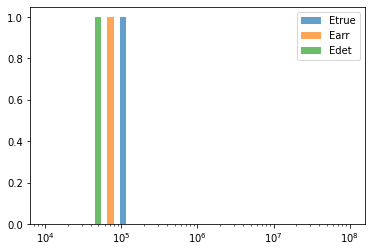

In [8]:
sim.show_spectrum()

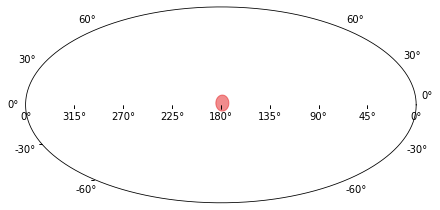

In [9]:
sim.show_skymap()

In [10]:
# Extract simulated data and get info needed for fit
fit_input_orig = sim.get_data()

In [11]:
fit_input_orig

OrderedDict([('N', 1),
             ('Edet', array([51512.00029955])),
             ('det_dir', array([[-0.99945413,  0.02389153,  0.02281757]])),
             ('source_dir',
              array([-9.96194698e-01,  1.21998665e-16,  8.71557427e-02])),
             ('D', 4.791180737568878e+25),
             ('z', 0.3),
             ('z_bg', 1.0),
             ('Emin', 100000.0),
             ('Emax', 100000000.0),
             ('T', 11207655.710943712),
             ('kappa', 209.77777777777777),
             ('aeff', 1.0)])

In [12]:
fit_input = copy.deepcopy(fit_input_orig)

## Classify

In [13]:
from nu_stats.fqutils import FqStructure
from nu_stats.bhmutils import BhStructure

In [14]:
fq = FqStructure()
fq.construct_atm_bg_energy_likelihood(
    Emin, Emax, n_Esim=100000,
    Nbins=50, prefab_likelihood_file='tmp/atmospheric_50lik.npy'
    )
fq.construct_source_energy_likelihood(
    fit_input['z'], Emin, Emax, min_index=1.5, max_index=4.0, n_Esim=100000,
    Nbins=25, prefab_likelihood_file='tmp/True0.3_25lik.npy'
)

bhm = BhStructure(fit_input)
bhm.load_model("stan/bhm_atm_fixedgamma.stan")


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/vmu/nu_stats/examples/stan/bhm_atm_fixedgamma
Generating atmospheric background energy likelihood..
Separate marginalized energy likelihood generated for bg.
Generating marginalized energy likelihood..
Marginalized energy likelihood generated.


In [15]:
bg_sim = Simulation(atm_flux_norm = 1/(u.GeV * u.cm**2 * u.s), Emin=Emin, Emax=Emax, Enorm=Enorm, N_events=100000)
bg_sim.run(seed=12345678)
bg_dat = bg_sim.get_data()

bg_TS = fq.test_stat(
    bg_dat['Edet'],
    bg_dat['det_dir'],
    gamma,
    fit_input['source_dir'],
    bg_dat['kappa']
    )


In [16]:
n_i = 50
Eds = np.logspace(4,7,n_i+1)[1:]
displs = np.linspace(0,.2,n_i) # pi*radians in circle

xv, yv = np.meshgrid(Eds, displs)
test_stat = np.zeros_like(xv)
p_vals = np.zeros_like(xv)
association = np.zeros_like(xv)

for i in range(n_i):
    for j in range(n_i):
        # Replace event
        Ed = xv[j,i]
        displ = yv[j,i]
        coord = SkyCoord(sim.ra*(1-displ), sim.dec * (1-2*displ), frame="icrs")
        coord.representation_type = "cartesian"
        dir = np.array([[coord.x.value, coord.y.value, coord.z.value]])
        fit_input['Edet'][0] = Ed
        fit_input['det_dir'][0] = dir

        # fq
        test_stat[j,i] = fq.test_stat(
            fit_input['Edet'],
            fit_input['det_dir'],
            gamma,
            fit_input['source_dir'],
            fit_input['kappa']
            )
        p_vals[j,i] = np.mean(bg_TS >= test_stat[j,i])

        # bh
        bhm.set_fit_input(fit_input)
        bhm.run()
        association[j,i] = bhm.association_probs()[:,0]


FO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4


In [27]:
cmap = plt.get_cmap('viridis')


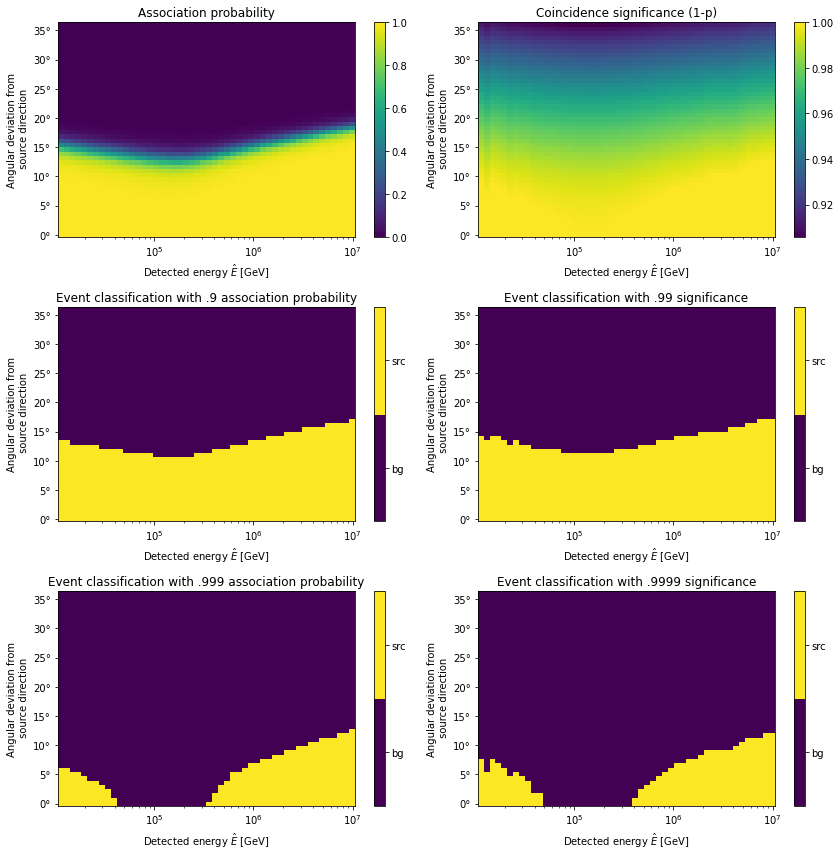

In [92]:
from matplotlib.ticker import StrMethodFormatter

d = {0:association, 1:1-p_vals, 2:association>.9, 3:(1-p_vals)>.99, 4:association>.999, 5:(1-p_vals)>.9999}
t = {0:'Association probability',
    1:'Coincidence significance (1-p)',
    2:'Event classification with .9 association probability',
    3:'Event classification with .99 significance',
    4:'Event classification with .999 association probability',
    5:'Event classification with .9999 significance'
     }
cmap = plt.get_cmap('viridis')
cmapb = matplotlib.colors.ListedColormap([cmap(0.0), cmap(1.0)])

fig,axs = plt.subplots(3,2)
for k in d.keys():
    if k>1:
        c = cmapb
    else:
        c = cmap
    ax = axs[np.unravel_index(k,(3,2))]
    mesh = ax.pcolormesh(xv,yv*180,d[k], shading = 'auto', vmax=1, cmap=c)
    ax.set_xscale('log')
    ax.set_xlabel(r'Detected energy $\hat{E}$ [GeV]')
    ax.set_ylabel('Angular deviation from\n source direction')
    ax.set_title(t[k])
    plt.locator_params(axis='y', nbins=10)
    ax.yaxis.set_major_formatter(StrMethodFormatter(u"{x:.0f}°"))
    if k>1:
        cbar = fig.colorbar(mesh, ticks= [.25,.75], ax=ax)
        cbar.ax.set_yticklabels(['bg', 'src'])
    else:
        cbar = fig.colorbar(mesh, ax=ax)
fig.set_size_inches((fig.get_size_inches()[0]*2,fig.get_size_inches()[1]*3))
plt.tight_layout()
plt.show()

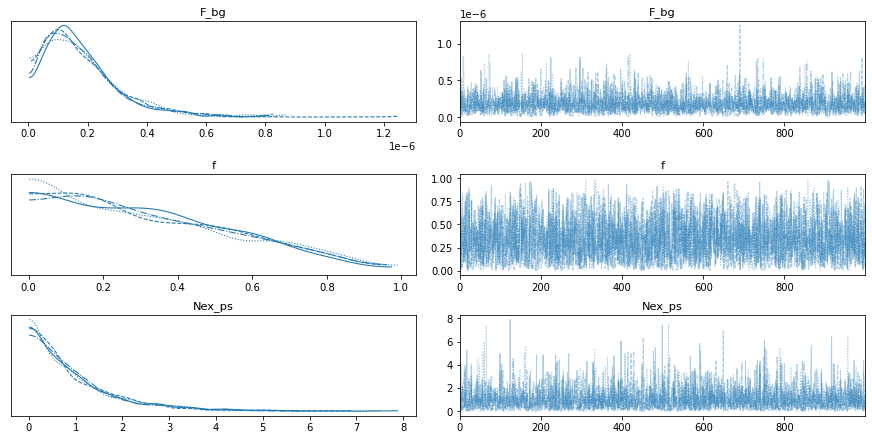

In [72]:
# Trace plot
var_names = ["F_bg", "f", "Nex_ps"]
bhm.plot_traces(var_names)
